###  dataset https://www.consumerfinance.gov/data-research/
https://www.consumerfinance.gov/data-research/consumer-complaints/

What the consumers were complaining in the financial product and service market? 
Data from these complaints help us understand the financial marketplace and protect consumers.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from pyspark import SparkContext
from pyspark.sql import Window
from pyspark.sql import SQLContext
#from pyspark.sql.functions import col, udf
import pyspark.sql.functions as F
from pyspark.sql.functions import split, explode
#from pyspark.sql.functions import regexp_replace, trim, col, lower
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StructType, StructField, DateType, IntegerType, StringType, DoubleType, TimestampType,ArrayType

from pyspark.ml.feature import Tokenizer, RegexTokenizer

NLP related installation and import

In [0]:
#word cloud
!pip install wordcloud
from wordcloud import WordCloud 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

In [0]:
#!/bin/bash
!pip install nltk
!pip install --upgrade pip
!nltk.downloader all

import nltk
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('twitter_samples')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('ieer')
nltk.download('stopwords')
#stopwords = set(STOPWORDS) 
stopwords = nltk.corpus.stopwords.words('english')
english_words = set(nltk.corpus.words.words())
#########
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data] Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data] /root/nltk_data...
[nltk_data] Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data] /root/nltk_data...
[nltk_data] Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data] Unzipping corpora/words.zip.
[nltk_data] Downloading package ieer to /root/nltk_data...
[nltk_data] Unzipping corpora/ieer.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Unzipping corpora/stopwords.zip.

In [0]:
#palette for seaborn
palette_colors = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878',
                    '#A040A0', '#F8D030','#E0C068','#EE99AC','#C03028', 
                    '#F85888', '#B8A038','#705898','#98D8D8','#7038F8']

#### 1.1 Data acquisition
- download [json format datasource](http://files.consumerfinance.gov/ccdb/complaints.json.zip) to local storage and unzip. Upload the unzipped json file to DBFS
- read json file and partion by 
- create dellta table. Delta Engine is a high performance, Apache Spark compatible query engine that provides an efficient way to process data in data lakes including data stored in open source Delta Lake. Delta Engine optimizations accelerate data lake operations, supporting a variety of workloads ranging from large-scale ETL processing to ad-hoc, interactive queries.

In [0]:
display(dbutils.fs.ls("dbfs:/FileStore/tables/"))

path,name,size
dbfs:/FileStore/tables/Matrices_for_ML_BB-1.ipynb,Matrices_for_ML_BB-1.ipynb,12948
dbfs:/FileStore/tables/Matrices_for_ML_BB.ipynb,Matrices_for_ML_BB.ipynb,12948
dbfs:/FileStore/tables/Unsupervised_Learning_PCA_BB.ipynb,Unsupervised_Learning_PCA_BB.ipynb,17665
dbfs:/FileStore/tables/complaints.csv,complaints.csv,1233411049
dbfs:/FileStore/tables/complaints.json,complaints.json,1942366519
dbfs:/FileStore/tables/exercise_pyspark_dataframe.ipynb,exercise_pyspark_dataframe.ipynb,30542
dbfs:/FileStore/tables/flight_model/,flight_model/,0
dbfs:/FileStore/tables/flight_weather.csv,flight_weather.csv,431664555


#####1.1.1 Pick up few data for observation.
Here we can see the 4 types of data data fields:
- date columns (yyyy-mm-dd format)
- some categorical columns
- narrative column (sentences)
- location related columns (state, zipcode)

In [0]:
# have quick view of the content of this json file
dbutils.fs.head("dbfs:/FileStore/tables/complaints.json", 4096)  

[Truncated to first 4096 bytes]
Out[7]: '[\n{"date_received": "2019-09-24", "product": "Debt collection", "sub_product": "I do not know", "issue": "Attempts to collect debt not owed", "sub_issue": "Debt is not yours", "complaint_what_happened": "transworld systems inc. \\nis trying to collect a debt that is not mine, not owed and is inaccurate.", "company_public_response": "", "company": "TRANSWORLD SYSTEMS INC", "state": "FL", "zip_code": "335XX", "tags": "", "consumer_consent_provided": "Consent provided", "submitted_via": "Web", "date_sent_to_company": "2019-09-24", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3384392"},\n{"date_received": "2019-09-19", "product": "Credit reporting, credit repair services, or other personal consumer reports", "sub_product": "Credit reporting", "issue": "Incorrect information on your report", "sub_issue": "Information belongs to someone else", "complaint_what_happened": "", "company_public_response": "Company has responded to the consumer and the CFPB and chooses not to provide a public response", "company": "Experian Information Solutions Inc.", "state": "PA", "zip_code": "15206", "tags": "", "consumer_consent_provided": "Consent not provided", "submitted_via": "Web", "date_sent_to_company": "2019-09-20", "company_response": "Closed with non-monetary relief", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3379500"},\n{"date_received": "2019-11-08", "product": "Debt collection", "sub_product": "I do not know", "issue": "Communication tactics", "sub_issue": "Frequent or repeated calls", "complaint_what_happened": "Over the past 2 weeks, I have been receiving excessive amounts of telephone calls from the company listed in this complaint. The calls occur between XXXX XXXX and XXXX XXXX to my cell and at my job. The company does not have the right to harass me at work and I want this to stop. It is extremely distracting to be told 5 times a day that I have a call from this collection agency while at work.", "company_public_response": "", "company": "Diversified Consultants, Inc.", "state": "NC", "zip_code": "275XX", "tags": "", "consumer_consent_provided": "Consent provided", "submitted_via": "Web", "date_sent_to_company": "2019-11-08", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3433198"},\n{"date_received": "2021-01-28", "product": "Credit reporting, credit repair services, or other personal consumer reports", "sub_product": "Credit reporting", "issue": "Problem with a credit reporting company\'s investigation into an existing problem", "sub_issue": "Investigation took more than 30 days", "complaint_what_happened": "", "company_public_response": "", "company": "EQUIFAX, INC.", "state": "FL", "zip_code": "33432", "tags": "", "consumer_consent_provided": "", "submitted_via": "Web", "date_sent_to_company": "2021-01-28", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "4102456"},\n{"date_received": "2019-09-15", "product": "Debt collection", "sub_product": "Other debt", "issue": "Attempts to collect debt not owed", "sub_issue": "Debt was result of identity theft", "complaint_what_happened": "Pioneer has committed several federal violations against me, a Private law abiding Federally Protected Consumer. Each violation is a statutory cost of {$1000.00} each, which does not include my personal cost and fees which shall be determined for taking time to address these issues. Violations committed against me include but not limited to : ( 1 ) Violated 15 USC 1692c ( a ) ; Communication without prior consent, expressed permission. ( 2 ) Violated 15 USC 1692d ; Harass and oppressive use of intercourse about an alleged debt. ( 3 ) Violated 15 USC 1692d ( l ) ; Attacking my reputation, accusing me of owing an alleged debt to you. ( 4 ) Violated 15 USC 1692e ( 9 ) ; Use/distribution of communication with auth

##### 1.1.2 load data into dataframe

In [0]:
from pyspark.sql.types import DateType
file_name = '/FileStore/tables/complaints.json'
#For a regular multi-line JSON file, set the multiLine option to true.
schema = """ `date_received`  DATE, 
`product`  STRING, 
`sub_product`  STRING, 
`issue`  STRING, 
`sub_issue`  STRING, 
`complaint_what_happened`  STRING, 
`company_public_response`  STRING, 
`company`  STRING, 
`state`  STRING, 
`zip_code`  STRING, 
`tags`  STRING, 
`consumer_consent_provided`  STRING, 
`submitted_via`  STRING, 
`date_sent_to_company`  DATE, 
`company_response`  STRING, 
`timely`  STRING, 
`consumer_disputed`  STRING, 
`complaint_id`  STRING""" 

sdf = spark.read.option("multiline",True).\
  json("/FileStore/tables/complaints.json", schema=schema)

#df = df.withColumn("complaint_id", df["complaint_id"].cast("bigint"))

To make sure data has been loaded smothly

In [0]:
#take 5 rows and have a clearer view with pandas dataframe
pd.DataFrame(sdf.take(5), columns=sdf.columns).transpose()

,0,1,2,3,4
date_received,2019-09-24,2019-09-19,2019-11-08,2021-01-28,2019-09-15
product,Debt collection,"Credit reporting, credit repair services, or o...",Debt collection,"Credit reporting, credit repair services, or o...",Debt collection
sub_product,I do not know,Credit reporting,I do not know,Credit reporting,Other debt
issue,Attempts to collect debt not owed,Incorrect information on your report,Communication tactics,Problem with a credit reporting company's inve...,Attempts to collect debt not owed
sub_issue,Debt is not yours,Information belongs to someone else,Frequent or repeated calls,Investigation took more than 30 days,Debt was result of identity theft
complaint_what_happened,transworld systems inc. \nis trying to collect...,,"Over the past 2 weeks, I have been receiving e...",,Pioneer has committed several federal violatio...
company_public_response,,Company has responded to the consumer and the ...,,,
company,TRANSWORLD SYSTEMS INC,Experian Information Solutions Inc.,"Diversified Consultants, Inc.","EQUIFAX, INC.",Pioneer Capital Solutions Inc
state,FL,PA,NC,FL,CA
zip_code,335XX,15206,275XX,33432,925XX


In [0]:
total = df.count()
print((total, len(df.columns)))

#### 1.2 Data cleansing
- Check date range, only keep the sent date from 2012-01-01 to 2019-12-31 (keep full-year data and exclude influence of covid-19)
- Delete data withought primary key (Complaint ID)
- remove empty states and outliers name

In [0]:
#https://blog.csdn.net/sinat_26917383/article/details/80500349
# delete null rows of these categorical columns, delete empty state and an outlier
sdf = sdf.filter("date_received>'2011-12-31' and date_received<'2020-01-01' " +
        "and state !='' and state!='UNITED STATES MINOR OUTLYING ISLANDS' ").\
        dropna(subset=['complaint_id', 'issue','product','date_received','company','state','submitted_via'])
# save cleaned data to table.
sdf.createOrReplaceTempView('t_complaints')

#### Feature engineering

##### features
- Add the length of the complaint content as a new feature named **complaint_len** and add **weekday_received** to show weekday number of the **weekday_received** column
- Processing date type columns
- What's the most complaint day in a week

In [0]:
from pyspark.sql import functions
from pyspark.sql.functions import date_format

sdf = sdf.withColumn("complaint_length", functions.length(F.col("complaint_what_happened"))).\
  withColumn("weekday_received", date_format(F.col("date_received"), "u")). \
  withColumn("year_received", F.year("date_received"))


Visualize the complaints amount by week

In [0]:
df_chart = df.groupBy("weekday_received")\
  .agg({"weekday_received":"count"})\
  .withColumnRenamed("count(weekday_received)", "count").toPandas()

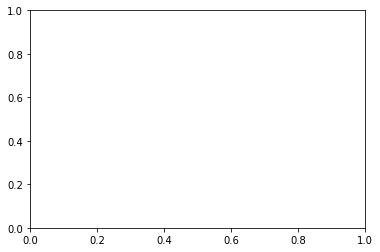

In [0]:
%matplotlib inline
ax = df_chart.plot.bar(x='label', y='count', title='Complaints by week', rot=45, xlabel='')
plt.show()

To count the number of complaints of each kind of **consumer_disputed** value

In [0]:
sdf.groupBy("consumer_disputed").count().show(truncate=False)

+-----------------+------+
consumer_disputed|count |
+-----------------+------+
No |613470|
N/A |686340|
Yes |146831|
+-----------------+------+

In [0]:
sdf.groupBy("tags").count().show(truncate=False)

+-----------------------------+-------+
tags |count |
+-----------------------------+-------+
Older American |82357 |
Servicemember |100746 |
 |1247068|
Older American, Servicemember|16470 |
+-----------------------------+-------+

#### 1.3 Data transformation

##### Drop unusful columns

##### 1.3.1 Convert categorical columns to numeric 
- process all categorical columns, generate _index column. Converts these columns of string values to label indexes.

In [0]:
#categorical string columns
cat_columns = ['product','sub_product',\
               'issue','sub_issue',\
               'submitted_via','company','company_response',\
               'consumer_consent_provided','timely']

cat_columns = ['product','sub_product',\
               'issue','sub_issue']
#pipeline
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in cat_columns ]
pipeline = Pipeline(stages=indexers)
#coresponding *_index columns are added to the new dataframe
df = pipeline.fit(df).transform(df)
          

File "<command-4181774045639223>" , line 1 
 import pyspark.ml.* 
 ^
 SyntaxError : invalid syntax

#### 2.1 Data visualization

#####2.1.1 What are the most complained by multiple dimensions, have they changed over time. 
- by product by year
- by submitted channel by year
- by company by year
- by issue by year

In [0]:
#we need to count group by year by each dimension, get the top rank items in each year, and visualize them with grouped chart. The below functions are for dealing with this issue. genChart
# for generating chart dataset
#generate group bar chart
def genBarchart(name, group_field_name, top_n=4):
  df = getRankByYear(group_field_name)
  years = df["sent_year"].unique()
  #begin year
  year1 = years[0];
  #end year
  year2 = years[-1]
  with sns.axes_style('white'):
    #show complaints amount by group_field_name by year
    g = sns.factorplot(x="sent_year", y="count", data=df, aspect=3.0, kind='bar',
                       palette=palette_colors,ci=None,hue=group_field_name, 
                       order=range(year1,year2),sharex=False,legend_out=False)
    g.set_ylabels('complaints amount')
    plt.legend(loc='best')
    #title - top n complaints by xxx begin_year - end_year
    g.fig.suptitle('top {} complaints by {} {} - {}'.format(top_n,name,year1,year2))
    
def getRankByYear(field_name, top_n=4):
  #top n complaints amount by year by field_name
  df_topn = sqlContext.sql("SELECT year(date_received) as sent_year," + \
                  field_name +\
                  " ,count(1) AS count " +\
                  " FROM t_complaints " +\
                  " GROUP BY year(date_received)," + field_name)
  w = Window.partitionBy("sent_year").orderBy(F.col("count").desc())
  df_topn_pd = df_topn.select("*",F.row_number().over(w).alias('rank')).\
    filter(F.col('rank') <= top_n).orderBy(F.col("sent_year")).toPandas()
  return df_topn_pd

###### 2.1.1.1 Where did the complaints come from? Did that changed over time?

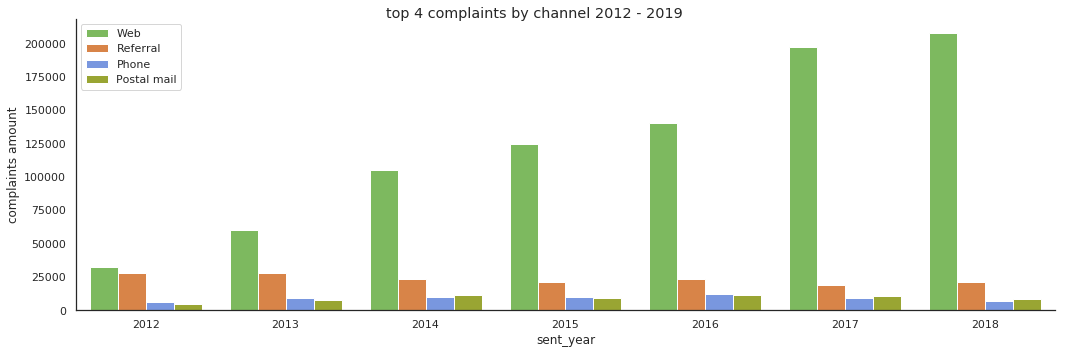

In [0]:
genBarchart("channel", "submitted_via")

###### 2.1.1.2 Which products get the most complaints? Have it changed over time?

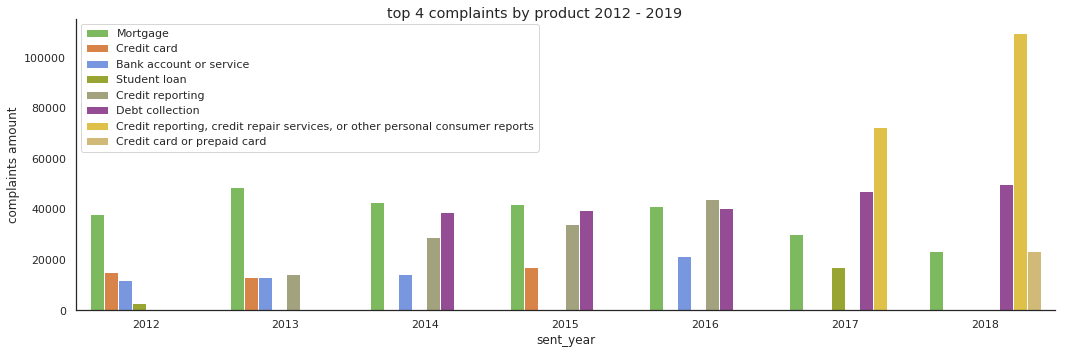

In [0]:
genBarchart("product", "product")

###### 2.1.1.3 Which companies got the most complaints? Have they improved over time?

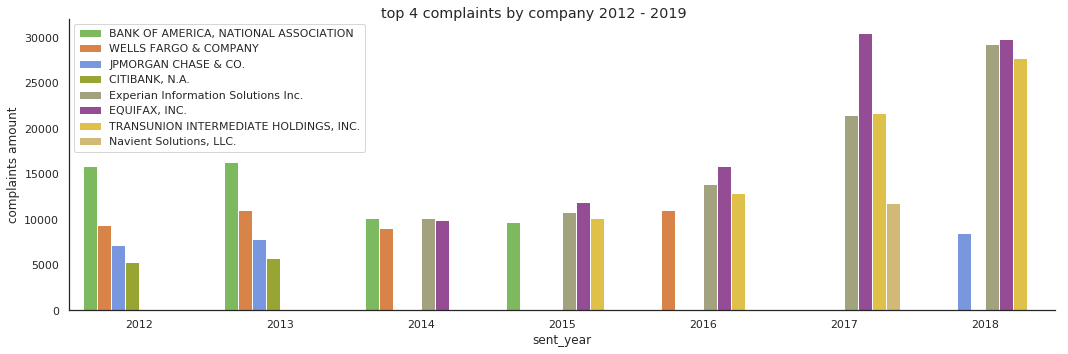

In [0]:
genBarchart("company", "company")

###### 2.1.1.4 Which companies got the most issues? Have they changed or improved over time?

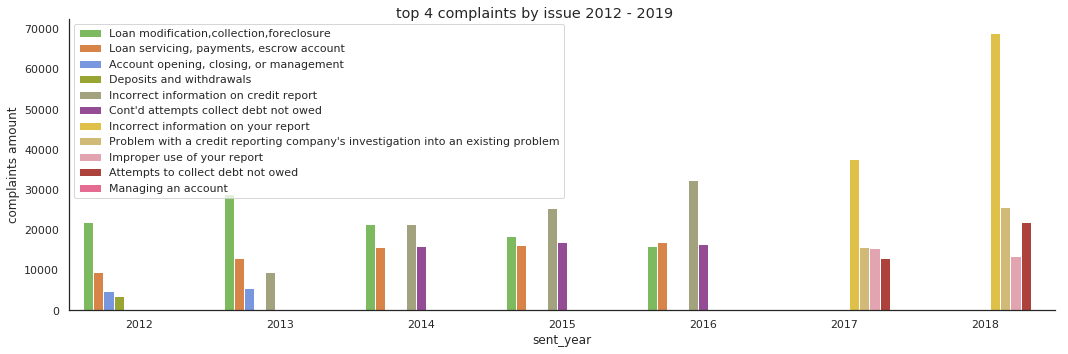

In [0]:
genBarchart("issue", "issue")

###### 2.1.1.5 Which states have the most complaints? Have they changed or improved over time?

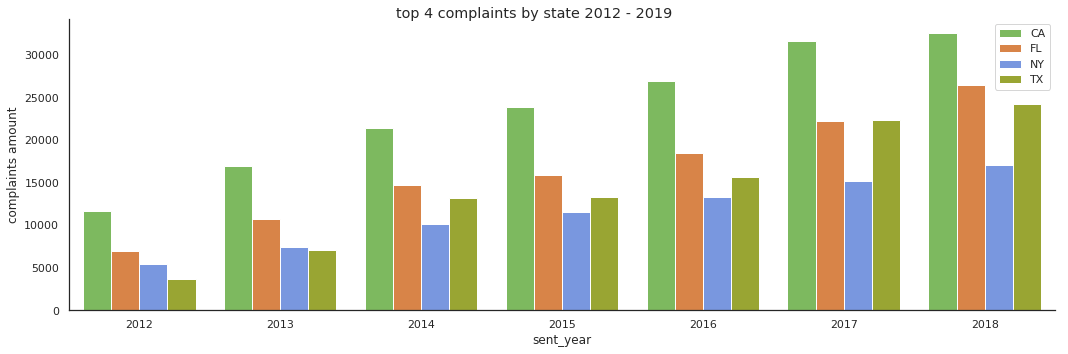

In [0]:
genBarchart("state", "state")

##### 2.1.1 Where are the complaints from
From annually top N rank of complaints amount by states, we can see
- the amount of complaints are all increased during the analysis period
- compare to the other top-ranked states which have shown slowdown in total complaints since 2017, the FL states shows rapid growth during the period given.
- the top N ranked states chart shows that the amount of complaints in the state is proportional to that of the population.

In [0]:
#group count by year by states and save the result to temp view: t_state_count
df_state_count = sqlContext.sql("SELECT year(date_received) as sent_year,state,count(1) AS count " + \
                  " FROM t_complaints " +\
                  " GROUP BY year(date_received),state")

- Show complaints distribution on the map.

In [0]:
df_state_count = sqlContext.sql("SELECT state,sum(count) AS value " + \
                  " FROM t_state_count WHERE state!='UNITED STATES MINOR OUTLYING ISLANDS' " +\
                  " GROUP BY state")
#stateRDD = sqlContext.createDataFrame(sc.parallelize())
#stateRDD.registerTempTable("test_state_table")

display(df_state_count)

##### 2.1.1 Top 4 complained products
- *Credit reporting, credit repair services, or other personal consumer reports*
- *Debt collection*
- *Mortgage*
- *Credit reporting*

In [0]:
df_product = sqlContext.sql("SELECT product,product_index,count(1) AS count " + \
                           " FROM t_complaints " +\
                           " GROUP BY product,product_index ORDER BY 3 DESC")
display(df_product)

##### 2.2.1 Checking sub-product to see what happened.
- There are two products refer to the Credit reporting, including **Credit reporting, credit repair services, or other personal consumer reports** and **Credit reporting**, and the sub product is **Credit reporting** or **Other personal consumer report** . Let's focus on credit report, and try to find what happened about this issue.
- 
Over 99% of these complaints are about Credit reporting

In [0]:
#filter those are credit report or consumer report related complaints
df_complaints_report = sqlContext.sql("SELECT product, sub_product,sub_product_index,count(1) AS count " + \
                           " FROM t_complaints " +\
                           " WHERE product_index in (0,3) " +\
                           " AND sub_product_index in (0,1,32) " +\
                           " GROUP BY product,sub_product,sub_product_index ORDER BY 4 DESC")
#save to table
df_complaints_report.createOrReplaceTempView('t_complaints_report')
display(df_complaints_report)

In [0]:
report_complaint_count = df_complaints_report.select(F.sum('count')).collect()[0][0]
#pd_count = pd.DataFrame(report_complaint_count, columns=report_complaint_count.columns
# almost 40% complaints is about credit reporting
#what's the proportion of these complaints, 32%, big
print((report_complaint_count/df_convert.count())*100)

##### 2.2.3 What's the issues about **Student loan**?
Among the nearly 40% of total complaints, what's the issues in it.
- There are many kinds of issues of these complaints data. Let's try to extract essential words from the detail of these issues.

In [0]:
# get narrative column
sdf_story = sqlContext.sql(\
                          " SELECT complaint_what_happened as content " +\
                          " FROM t_complaints WHERE " +\
                          " product='Student loan' AND " +\
                          #" sub_product_index in (0,1,32) AND " +\
                          " complaint_what_happened IS NOT NULL AND " +\
                          " complaint_what_happened !='' ")

In [0]:
#可以只提取名词吗
vstopwords = np.append(stopwords,["x","xx","xxx","xxxx","xxxxx","xxxxxxxx","xx/xx/xxxx"])
#extract content from specific field of the dataframe, and return 
def parseContent(df_story, field_name):
  #lower 
  df_story_clean = df_story.select(field_name, (F.lower(F.regexp_replace(field_name, 
                                                                         "[^a-zA-Z\\s]", "")).alias('out1')))
  #split story into words
  tokenizer = Tokenizer(inputCol="out1", outputCol="out2")
  #private infor has been replaced with x before the dataset published, such as date, name...
  #remove stop words
  stopWordsRemover = StopWordsRemover(inputCol='out2', outputCol='out3' ,stopWords=stopwords)
  #stem
  # keep English words with length greater than 3
  stemmer = SnowballStemmer('english')
  udf_stem = udf(lambda words: [stemmer.stem(word) for word in words if len(word)>3 and word in english_words and \
                               word in nltk.pos_tag(tokenized) if(pos[:2] == 'NN') ], ArrayType(StringType()))
  #pipeline
  pipeline = Pipeline(stages=[tokenizer, stopWordsRemover])
  return pipeline.fit(df_story_clean).transform(df_story_clean) \
      .select(field_name,"out3") \
      .drop("out1","out2") \
      .withColumn("words", udf_stem(F.col("out3"))).drop('out3')

In [0]:
display(df_words)

content words Payments to loan are not being properly applied to interest and principal. There will be months were {$0.00} are applied to principal and after an entire year of payments the over all principal only went down {$200.00}. When I contacted the lender about ways reduce the interest the only offered a 0.25 % reduction for auto debits which I signed up for. The next month, the payment remained unchanged as the variable interest on the loan increased again to around 8.5 % I make regular payments to this loan and I just want to find a way to get out from underneath it quicker. List(loan, proper, appli, interest, princip, appli, princip, entir, year, princip, went, lender, way, reduc, interest, reduct, auto, next, month, payment, unchang, variabl, interest, loan, around, make, regular, loan, want, find, underneath) My original lender was XXXX XXXX XXXX ; this loan was considered a private loan that my parents took out to pay for my college education. XXXX XXXX XXXX had switched servicers to XXXX XXXX. The original promissory note I have, shows my father as applicant # 1/borrower, my mother as applicant # 2/co-borrower, and myself as student. This loan originated in XX/XX/XXXX. My father and I share the same name and I feel that has added confusion. My father always made the payments on this loan, as well as, collected tax documents and deductions on this loan, as the borrower. In XX/XX/XXXX, my father passed away from XXXX. My mother contacted XXXX and she was told about loan forgiveness. She submitted my fathers death certificate and she waited 32 days for an answer. Unfortunately, they did not approve the loan for forgiveness. Instead, XXXX has switched me, from student, to borrower and my mother stays as co-borrower. How did I go from being a student on a promissory note, to now the sole borrower? I have called XXXX, and it has been unsuccessful. I have requested documents including the denial letter stating why the loan wasnt forgiven as a result of my father 's death, the promissory note they have on file, as well as the loan terms indicating that I am now legally responsible for this loan. I have had no success in retrieving these documents. I have been told that I am not entitled to these documents from XXXX and to contact XXXX XXXX XXXX for the promissory note. I was told by a XXXX representative that the promissory note they have on file is not legible and she couldnt confirm who was supposed to be borrower/co-borrower. I have contacted XXXX XXXX XXXX, for a copy of the promissory note, by email. I was told by XXXX XXXX XXXX that they do not have the promissory note and to refer to XXXX copy. I have responded to their initial email, requesting more information and they have not responded. There is no contact information for XXXX XXXX XXXX, just an email address. I am doubtful of the information I have been given. I feel I should be entitled to a copy of the denial letter, as well as a legible copy of the promissory note. I would also like to see a copy of the loan terms indicating how I went from being a student, to now the main borrower. I want documentation, and feel it is my consumer right, to have proof that XXXX has that ability to change borrowers and to choose who is made responsible. Though Im hopeful for your timely response and subsequent resolution of my issues, Im fully aware of the 'not-so-positive ' reviews/feedback given to XXXX XXXX and, therefore, will be prepared to submit additional complaints to the XXXX XXXX XXXX , and the Ohio Attorney General. List(origin, lender, loan, consid, privat, loan, took, colleg, educ, switch, origin, promissori, note, father, applic, borrow, mother, applic, student, loan, father, share, name, feel, ad, confus, father, alway, made, loan, well, collect, loan, borrow, father, away, mother, told, loan, forgiv, death, certif, day, answer, unfortun, approv, loan, forgiv, instead, switch, student, borrow, mother, stay, student, promissori, note, sole, borrow, unsuccess, 

In [0]:
df_words = parseContent(sdf_story,"content")
#explode words column and group count each word
df_word_count = df_words.select(explode("words").alias('word')).\
  groupby('word').count().sort(F.desc("count")).toPandas()

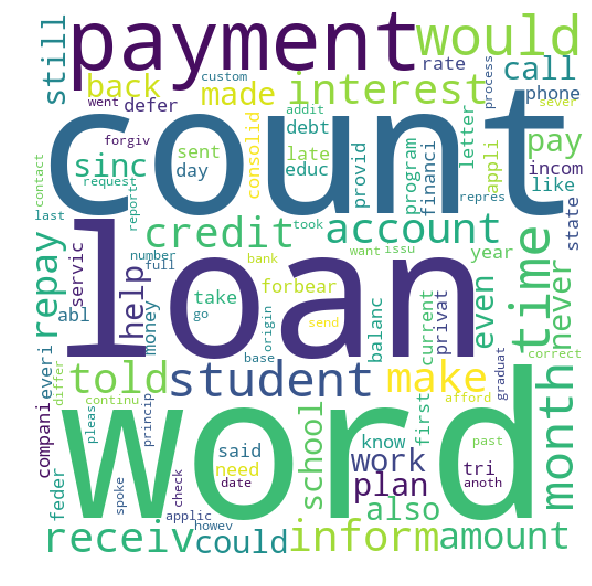

In [0]:
%matplotlib inline
#combine word and count column to map, and parse it to wordcloud
#data = dict(zip(df_word_count.select('word').collect(),df_word_count.select('count').collect()))
#wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data)


wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(df_word_count[0:100].to_string()) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 
df_word_count.to_string()

We start with the **complaint_what_happened**, split the sentences into words tokenizer, and hash the sentences into a feature vector. and generate feature vectors for machine learning instead of using the text as features.

#### 3.1 Machine learning

##### Drop unusful columns for prediction

In [0]:
import org.apache.spark.ml.feature.HashingTF

hashingTF = new HashingTF() \
  .setInputCol("words").setOutputCol("rawFeatures").setNumFeatures(20)
lr = LogisticRegression(maxIter=7)
pipeline = Pipeline(stages=[hashingTF,lr])
# Fit the model to the data.
model = pipeline.fit(df_words)

# Given a dataset, predict each point's label, and show the results.
#model.transform(df_word).show()

File "<command-712661231093573>" , line 3 
 hashingTF = new HashingTF() \ 
 ^
 SyntaxError : invalid syntax

##### 3.1.1 apply Logistic Regression

In [0]:
lr = LogisticRegression(maxIter=10)
# Fit the model to the data.
model = lr.fit(df)
# Given a dataset, predict each point's label, and show the results.
model.transform(df_word).show()

##### 2.2.4 Which company contributed this issue most?
- Check how this issue distributed in within these companies. Have they dealed these complaints timely?
TRANSUNION INTERMEDIATE HOLDINGS, INC. , Experian Information Solutions Inc. and EQUIFAX, INC. have the highest count of complaints on this issue. By google these companies, we can find these are established for over 30 years financial company. Is this because they have a big consumer group?

##### 2.2.5 summary report

In [0]:
sqlContext.sql("
               SELECT * product, year
               ")

##### 2.2.9 Let's generate words cloud to have a clear insight about the consumers' complaints
- split issue, sub_issue and narrative fields

##### Which company contributed this issue most?
- Check how this issue distributed in within these companies. Have they dealed these complaints timely?
TRANSUNION INTERMEDIATE HOLDINGS, INC. , Experian Information Solutions Inc. and EQUIFAX, INC. have the highest count of complaints on this issue. By google these companies, we can find these are established for over 30 years financial company. Is this because they have a big consumer group?

In [0]:
df_company_issue = sqlContext.sql("SELECT company,count(1) as count, " + \
                           " round((sum(IF(timely='No', 1, 0))/count(1))*100,2) as delay_percent " +\
                           " FROM t_complaints " +\
                           " WHERE PRODUCT='Credit reporting, credit repair services, or other personal consumer reports' " +\
                           " AND sub_product='Credit reporting' " +\
                           " AND issue='Incorrect information on your report' AND sub_issue='Information belongs to someone else' "\
                           " GROUP BY company")
display(df_company_issue)

###### How can we look further?
- Using web crawler, check the user amount of this company. 
- Checking the narrative, generating words cloud to see.
- From time aspect, check whether these issued have been fixed. 

These top 3 companies all have timely response, so this time let's only focus on the amount about this issue during these years. 
The line chart shows, from 2015 by now, this issue has been increased gradually instead of improved. Since 2020, the complaints amount increased greatly.

In [0]:
df_company_improve = sqlContext.sql("SELECT company,date_received,to_timestamp(date_received, 'yyyy-MM') as received_ym," + \
                           " count(1) as total "         
                           " FROM t_complaints " +\
                           " WHERE PRODUCT='Credit reporting, credit repair services, or other personal consumer reports' " +\
                           " AND sub_product='Credit reporting' " +\
                           " AND issue='Incorrect information on your report' AND sub_issue='Information belongs to someone else' "\
                           " AND ((company='TRANSUNION INTERMEDIATE HOLDINGS, INC.')  "
                           " OR (company='Experian Information Solutions Inc.')  "
                           " OR (company='EQUIFAX, INC.'))  "
                           " GROUP BY company,date_received,to_timestamp(date_received, 'yyyy-MM')")

display(df_company_improve)

company,date_received,received_ym,total
"EQUIFAX, INC.",2019-08-12,2019-08-12T00:00:00.000+0000,75
"TRANSUNION INTERMEDIATE HOLDINGS, INC.",2019-05-22,2019-05-22T00:00:00.000+0000,60
Experian Information Solutions Inc.,2018-08-21,2018-08-21T00:00:00.000+0000,36
"EQUIFAX, INC.",2019-11-20,2019-11-20T00:00:00.000+0000,81
Experian Information Solutions Inc.,2019-11-23,2019-11-23T00:00:00.000+0000,36
"EQUIFAX, INC.",2019-10-30,2019-10-30T00:00:00.000+0000,65
Experian Information Solutions Inc.,2019-11-16,2019-11-16T00:00:00.000+0000,32
"TRANSUNION INTERMEDIATE HOLDINGS, INC.",2017-06-30,2017-06-30T00:00:00.000+0000,8
Experian Information Solutions Inc.,2018-09-25,2018-09-25T00:00:00.000+0000,30
Experian Information Solutions Inc.,2018-06-20,2018-06-20T00:00:00.000+0000,20


#### By taking some sampling data, we have seen what the data looks like.
- **complaint_what_happened** is the description of what that consumer complained. By applying nlp related analysis, can we find the sentiment of these records. This is all about complaints, but there usually exists different levels of severity. If we can analysis these levels, it might be used for the future classification.
- Check the columns which have these standard items
- **date_received** and **date_sent_to_company** for applying time series analysis

- Clearing text from punctuation (regexp_replace)
 - Tokenization (Tokenizer)
 - Delete stop words (StopWordsRemover)
 - Stematization (SnowballStemmer)
 - Filtering short words (udf)

###NLP
-  DocumentAssembler(), one of the most essential transformers of the Spark NLP library. It’s the entry point to get your data in, and then process further with annotators. And, without linking its output to annotators in a pipeline, it has no meaning. In the following articles, we will talk about how you can apply certain NLP tasks on top of DocumentAssembler()

#### Where are these customers, in which way they complained.
 - using geo information to visualize the distribution of these consumers.
 - count the complaint record by source.

### 3 Machine Learning
- Can we predict the the sentiment of the consumers by extracting the story of these complaints.
- Can we predict the issue or product by extracting the consumer's story and other columns
- Can we predict the close type ?

#### 3.1 Feature processing
- Prepare features.

In [0]:
sdf.createOrReplaceTempView('t_complaints')
sdf.columns

Out[113]: ['date_received',
 'product',
 'sub_product',
 'issue',
 'sub_issue',
 'complaint_what_happened',
 'company_public_response',
 'company',
 'state',
 'zip_code',
 'tags',
 'consumer_consent_provided',
 'submitted_via',
 'date_sent_to_company',
 'company_response',
 'timely',
 'consumer_disputed',
 'complaint_id',
 'complaint_length',
 'weekday_received',
 'year_received']

In [0]:
#dataset for machine learning
sdf_ml = sqlContext.sql("SELECT product,issue,state,company,weekday_received,company_public_response " + \
                  " FROM t_complaints")

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(words)

from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(vectorizer.transform(words),y_train)

作者：炼己者
链接：https://www.zhihu.com/question/268849350/answer/488389597
来源：知乎
著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。

In [0]:
trainDF, testDF = df.randomSplit([0.8, 0.2], seed=42)
print(trainDF.cache().count()) # Cache because accessing training data multiple times
print(testDF.count())
#these are some categorical string columns, add according code column to make it easier to process
#nominal columns
cat_columns = ['product',\
               'issue',\
               'state','company_response',\
               ,'company_public_response']
#ordinal columns 
#'weekday_received'
#pipeline
indexers = StringIndexer(inputCols=categoricalCols, outputCols=[x + "Index" for x in cat_columns]) 
pipeline = Pipeline(stages=indexers)
#coresponding *_index columns are added to the new dataframe
sdf_ml = pipeline.fit(df).transform(df)

#### 3.1 Definae the model
- Define the model.

#### 3.2 Buil the pipeline
- pipeline.....

#### 3.3 Evaluate the model
- pipeline.....

#### 3.4 Hyperparameter tuning
- tunning.....

#### 3.5 Make predictions and evaluate model performance
- prediction.....

In [0]:
/**
 * Step 3
 * Define a VectorAssembler transformer to transform source features data to be a vector
 * This is helpful when raw input data contains non-feature columns, and it is common for
 * such a input data file to contain columns such as "ID", "Date", etc.
 */
 val vectorAssembler = new VectorAssembler()
 .setInputCols(Array("f0","f1","f2","f3"))
 .setOutputCol("featureVector")

 /**
 * Step 4
 * Create RandomForestClassifier instance and set the input parameters.
 * Here we will use 5 trees Random Forest to train on input data.
 */
 val rfClassifier = new RandomForestClassifier()
 .setLabelCol("indexedLabel")
 .setFeaturesCol("featureVector")
 .setNumTrees(5)

 /**
 * Step 5
 * Convert indexed class labels back to original one so that it can be easily understood when we
 * need to display or save the prediction result to a file.
 */
 val labelConverter = new IndexToString()
 .setInputCol("prediction")
 .setOutputCol("predictedLabel")
 .setLabels(labelIndexer.labels)

 //Step 6
 //Randomly split the input data by 8:2, while 80% is for training, the rest is for testing.
 val Array(trainingData, testData) = df.randomSplit(Array(0.8, 0.2))

 /**
 * Step 7
 * Create a ML pipeline which is constructed by for 4 PipelineStage objects.
 * and then call fit method to perform defined operations on training data.
 */
 val pipeline = new Pipeline().setStages(Array(labelIndexer,vectorAssembler,rfClassifier,labelConverter))
 val model = pipeline.fit(trainingData)

 /**
 *Step 8
 *Perform predictions about testing data. This transform method will return a result DataFrame
 *with new prediction column appended towards previous DataFrame.
 *
 * */
 val predictionResultDF = model.transform(testData)

 /**
 * Step 9
 * Select features,label,and predicted label from the DataFrame to display.
 * We only show 20 rows, it is just for reference.
 */
 predictionResultDF.select("f0","f1","f2","f3","label","predictedLabel").show(20)

 /**
 * Step 10
 * The evaluator code is used to compute the prediction accuracy, this is
 * usually a valuable feature to estimate prediction accuracy the trained model.
 */
 val evaluator = new MulticlassClassificationEvaluator()
 .setLabelCol("label")
 .setPredictionCol("prediction")
 .setMetricName("precision")
 val predictionAccuracy = evaluator.evaluate(predictionResultDF)
 println("Testing Error = " + (1.0 - predictionAccuracy))
 /**
 * Step 11(Optional)
 * You can choose to print or save the the model structure.
 */
 val randomForestModel = model.stages(2).asInstanceOf[RandomForestClassificationModel]
 println("Trained Random Forest Model is:\n" + randomForestModel.toDebugString)
 }
}

##### 1.1.1 With this model, the company can predict their new product campaingn strategy based on the least complaints and product type, date.   + population
- input:big company, date, product type,least complained state
- output: state

less complaints=>more productive
- big company has sold A product. 100 people get it, 99%complained. than means product performs very bad here.
complaint rate of a product represent the performance of selling this product.

complaints /(product_sell_amount) =>performance

##### 1.1.2 With this model, the company can predict their new product campaingn strategy based on the least complaints and product type, date.  + population
- input:product,max complained state name, big company, date
- output: state
complaints rate!!!!不适合发布新产品

In [0]:
visualization
product==>least complaints /most complaints state 

预测是否max complaints
1、existing product==>which state wil have max complaints in  A specific 
基于历史数据最多抱怨的product 

In [0]:
# Register a UDF to convert the feature (2014_Population_estimate) column vector to a VectorUDT type and apply it to the column.
from pyspark.ml.linalg import Vectors, VectorUDT

spark.udf.register("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())
tdata = pop_df.select(*exprs).selectExpr("oneElementVec(2014_Population_estimate) as features", "2015_median_sales_price as label")

# Run a linear regression
from pyspark.ml.regression import LinearRegression

lr = LinearRegression()
modelA = lr.fit(tdata, {lr.regParam:0.0})

# Plot residuals versus fitted data
display(modelA, tdata)